In [1]:
import math
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms.functional as TVF
from PIL import Image
from voronoi_interp_torch import voronoi_interpolate

# Example

In [2]:
img = TVF.to_tensor(Image.open('./demo.png'))[:3, :, :].cuda()
H, W = img.shape[1], img.shape[2]
coords = torch.stack(torch.meshgrid(torch.arange(H), torch.arange(W))[::-1], dim=2).view(-1, 2).cuda()
coords = coords[torch.randperm(coords.shape[0])]
values = img[:, coords[:, 1], coords[:, 0]].T

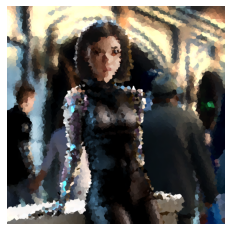

In [3]:
count = 10000
img_ref = voronoi_interpolate(coords[:count], values[:count], H, W)
plt.imshow(img_ref.permute(1, 2, 0).detach().cpu())
plt.axis('off')
plt.show()

In [4]:
torch.allclose(img, voronoi_interpolate(coords, values, H, W))

True

# Create video

In [5]:
fps = 5
duration = 7
exponent = 0.8
step = 1 / (fps * duration)
interp_target = math.log(len(coords))

t = step
images = []
for i in range(duration * fps):
    count = min(round(math.exp(interp_target * math.pow(t, exponent))), len(coords))
    result_img = voronoi_interpolate(coords[:count], values[:count], H, W)
    images.append((result_img.detach().cpu() * 255).type(torch.uint8).permute(1, 2, 0))
    print(f"timestep {round(t, 2)}, {count} pixels out of {len(coords)}")
    t += step

timestep 0.03, 2 pixels out of 1048576
timestep 0.06, 4 pixels out of 1048576
timestep 0.09, 7 pixels out of 1048576
timestep 0.11, 12 pixels out of 1048576
timestep 0.14, 19 pixels out of 1048576
timestep 0.17, 29 pixels out of 1048576
timestep 0.2, 46 pixels out of 1048576
timestep 0.23, 71 pixels out of 1048576
timestep 0.26, 107 pixels out of 1048576
timestep 0.29, 162 pixels out of 1048576
timestep 0.31, 243 pixels out of 1048576
timestep 0.34, 361 pixels out of 1048576
timestep 0.37, 532 pixels out of 1048576
timestep 0.4, 781 pixels out of 1048576
timestep 0.43, 1140 pixels out of 1048576
timestep 0.46, 1655 pixels out of 1048576
timestep 0.49, 2391 pixels out of 1048576
timestep 0.51, 3441 pixels out of 1048576
timestep 0.54, 4933 pixels out of 1048576
timestep 0.57, 7043 pixels out of 1048576
timestep 0.6, 10021 pixels out of 1048576
timestep 0.63, 14211 pixels out of 1048576
timestep 0.66, 20089 pixels out of 1048576
timestep 0.69, 28313 pixels out of 1048576
timestep 0.71, 3

In [6]:
# video = torch.stack(images, dim=0)
# torchvision.io.write_video("demo.mp4", video, fps)

In [7]:
# import imageio
# imageio.mimsave('demo.gif', images)

# Optimization

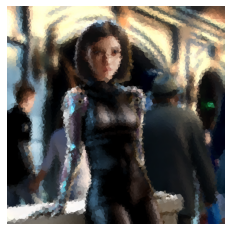

In [8]:
import torch.nn as nn
import torch.nn.functional as F

count = 10000
img_ref = voronoi_interpolate(coords[:count], values[:count], H, W)
img_ref = (img_ref.detach().cpu() * 255).type(torch.uint8).permute(1, 2, 0)
values_mse = torch.rand_like(values[:count], requires_grad=True).cuda()

optimizer = torch.optim.Adam([values_mse], lr=0.1)

images_mse = []
for i in range(120):
    img_mse = voronoi_interpolate(coords[:count], values_mse, H, W)
    images_mse.append((img_mse.detach().cpu() * 255).type(torch.uint8).permute(1, 2, 0).clamp(0, 255))
    loss = F.mse_loss(img_mse, img)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
plt.imshow(images_mse[-1])
plt.axis('off')
plt.show()

In [9]:
# import imageio
# imageio.mimsave('opt.gif', images_mse)